In [20]:
from dotenv import load_dotenv
load_dotenv()

True

In [21]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import chromadb

In [22]:

import chromadb
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# Load the existing collection
client = chromadb.PersistentClient(path="./knowledge-base-collection")
embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    client=client,
    collection_name='knowledge-base-collection',
    embedding_function=embedding_function
)

# Create retriever
retriever = vector_store.as_retriever(search_kwargs={'k': 3})


In [23]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str
    
graph_builder = StateGraph(AgentState)

In [24]:
def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [25]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [26]:
from langchain import hub 

generate_prompt = hub.pull('rlm/rag-prompt')

generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100) #why max token 100?

def generate(state: AgentState) -> AgentState:
    context = state['context']
    query = state['query']
    
    rag_chain = generate_prompt | generate_llm
    
    response = rag_chain.invoke({'question':query,'context':context})
    
    return {'answer': response.content}

In [27]:
from typing import Literal

doc_relevance_prompt = hub.pull('langchain-ai/rag-document-relevance')

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    query = state['query']
    context = state['context']
    
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question':query, 'documents': context})
    
    if response['Score'] == 1:
        return 'relevant'
    return 'irrelevant'

In [28]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

rewrite_prompt = PromptTemplate.from_template("""
You are a helpful query rewriting assistant for a Retrieval-Augmented Generation (RAG) system.

Your goal:
- Make the user’s question clearer and more retrieval-friendly *only if truly necessary*.
- If the question is already clear, specific, and meaningful, do NOT rewrite it.
- Avoid trivial rewordings or restating the same idea in different words.
- Do not enter a rewrite loop — stop rewriting if the query already makes sense.

Output format:
Return ONLY the final query text (no explanations or reasoning).

User question: {{query}}
Rewritten query:
""")

def rewrite(state: AgentState) -> AgentState:
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})
    return {'query': response}

In [29]:
from langchain_core.output_parsers import StrOutputParser

hallucination_prompt = PromptTemplate.from_template("""
You are a teacher tasked with evaluating whether a student's answer is based on documents or not,
Given documents, which are excerpts from kdu(kyungdong university) global campus, and a student's answer;
If the student's answer is based on documents, respond with "not hallucinated",
If the student's answer is not based on documents, respond with "hallucinated".

documents: {documents}
student_answer: {student_answer}
""")

hallucination_llm = ChatOpenAI(model='gpt-4o', temperature=0)

def check_hallucination(state: AgentState) -> Literal['hallucinated', 'not hallucinated']:
    answer = state['answer']
    context = state['context']
    context = [doc.page_content for doc in context]
    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    response = hallucination_chain.invoke({'student_answer': answer, 'documents': context})

    return response
     

In [30]:
# Pull the helpfulness prompt from the LangChain Hub
helpfulness_prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def check_helpfulness_grader(state: AgentState) -> str:
    """
    Evaluates the helpfulness of the generated answer based on the user's question.

    Args:
        state (AgentState): The current agent state containing the user's question
                            and the generated answer.

    Returns:
        str: Returns 'helpful' if the answer is judged to be helpful,
             otherwise returns 'unhelpful'.
    """
    # Extract the question and answer from the state
    query = state['query']
    answer = state['answer']

    # Create a chain to evaluate the helpfulness of the answer
    helpfulness_chain = helpfulness_prompt | llm

    # Invoke the chain with the question and answer
    response = helpfulness_chain.invoke({
        'question': query,
        'student_answer': answer
    })

    # Return 'helpful' if the score is 1, otherwise return 'unhelpful'
    if response['Score'] == 1:
        return 'helpful'

    return 'unhelpful'


def check_helpfulness(state: AgentState) -> AgentState:
    """
    Placeholder function for checking helpfulness.
    This is used to improve readability by adding a node instead of
    using consecutive conditional edges in the graph.

    Args:
        state (AgentState): The current agent state.

    Returns:
        AgentState: Returns the state unchanged.
    """
    # This function currently performs no operation and returns the state as-is
    return state


In [31]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('check_helpfulness', check_helpfulness)

In [32]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelevant': END 
    }
)
graph_builder.add_conditional_edges(
    'generate',
    check_hallucination,
    {
        'not hallucinated': 'check_helpfulness',
        'hallucinated': 'generate'
    }
)
graph_builder.add_conditional_edges(
    'check_helpfulness',
    check_helpfulness_grader,
    {
        'helpful': END,
        'unhelpful': 'rewrite'
    }
)
graph_builder.add_edge('rewrite','retrieve')

In [33]:
graph = graph_builder.compile()

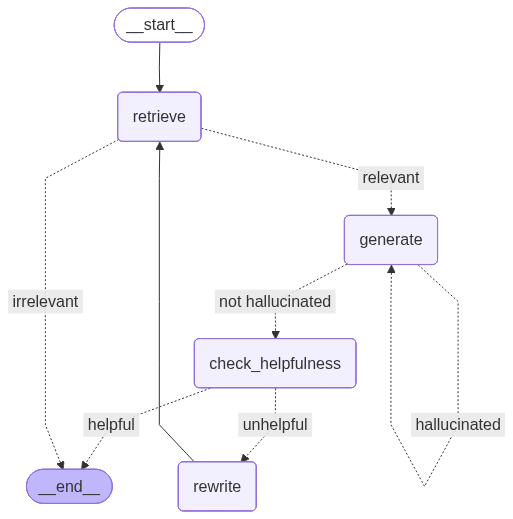

In [34]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
initial_state = {'query': 'what scholarship options are there in kdu?'}
graph.invoke(initial_state)

{'query': 'what scholarship options are there in kdu?',
 'context': [Document(id='c010d18c-2ab0-4000-8815-26b2267ca495', metadata={'doc_type': 'Admissions', 'source': 'knowledge-base-documents\\Admissions\\Scholarships and Fees _ Kyungdong University.txt'}, page_content="Undergraduate and\nAverage grade of 80%: 50%\nscholarship.\n\n\ngraduate students.\nAverage grade of 90%: 70% scholarship.\n\n\nRange: up to 100% of\ntuition fee.\nAverage grade of 95% or above: 100% scholarship.\n\nGraduate courses:\nAverage grade of 80%: 50% scholarship.\n\nAverage grade of 90% or above: 70% scholarship.\n\nKDU Global\nGranted to students who\nUndergraduate and graduate students who demonstrate exemplary contribution to KDU Global and commitment to their studies with:\nOfficial recommendations by Deans and Heads of Departments\nNot more than three hours of unexcused absence in each subject enrolled.\nBased on individual\nCitizen\nScholarship\nuphold core principles in discipline, moral values,\n\nass